In [326]:
UC = [0] + [5]*9 + [25]*7 + [5]*8
CAPA=[15,14,16,10,17,16,15,18]
inventory = [30,28,32,20,34,32,30,36]
SC = 100
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver('SCIP')
#각 시간별 각 기계의 생산량
P={}
for i in range(8):
    for j in range(1,25):
        P[i,j]=solver.IntVar(0, solver.infinity(), 'p[%i,%i]' % (i,j))
#각 시간별 각 기계의 가동 여부
Y={}
for i in range(8):
    for j in range(25):
        Y[i,j]=solver.BoolVar('x[%i,%i]' % (i,j))
#각 시간 말의 각 기계별 재고량
I={}
for i in range(8):
    for j in range(25):
        I[i,j]=solver.IntVar(0, solver.infinity(), 'i[%i,%i]' % (i,j))
#setup시간 발생 여부
S={}
for i in range(8):
    for j in range(1,25):
        S[i,j]=solver.BoolVar('s[%i,%i]' % (i,j))



In [327]:
#제약조건1: 각 시간별 생산량은 앞서 쌓인 재고량보다 작거나 같다
for i in range(1,8):
    for j in range(1,25):
        solver.Add(P[i,j] <= I[i,j])
#첫 기계는 재고에 의한 생산량 제약 없음
#제약조건2: 초기 재고량은 주어진 값과 같다.
for i in range(7):
    solver.Add(I[i,0] == inventory[i])
solver.Add(I[7,0] == 0)  # 마지막 기계의 초기 재고량은 0으로 설정
#제약조건3: 각 재고량은 생산량과 이전 재고량의 합으로 계산된다.
for i in range(7):
    for j in range(1,25):
        solver.Add(I[i,j] == I[i,j-1] + P[i,j]- P[i+1,j])
#제약조건4: 마지막 재고량은 초기 재고량과 같아야한다.
for i in range(7):
    solver.Add(I[i,24] == inventory[i])
for j in range(1,25):
    solver.Add(I[7,j] == I[7,j-1] + P[7,j])  # 마지막 기계의 재고량은 이전 시간의 재고량과 현재 생산량의 합
solver.Add(I[7,24] == min(CAPA)*24)  # 마지막 기계의 최종 재고량은 병목공정의 생산량량으로 설정

#제약조건5: 각 기계의 생산량은 해당 기계의 가동 여부에 따라 결정된다.
for i in range(8):
    for j in range(1,25):
        solver.Add(P[i,j] <= Y[i,j] * CAPA[i])
        solver.Add(P[i,j] >= Y[i,j])#생산이 없는 경우 Y[i,j]는 0이 되게 함
#제약조건6: setup 시간은 가동 여부에 따라 결정된다.
for i in range(1,8):
    for j in range(1,25):
        solver.Add(S[i,j]>=Y[i,j]-Y[i-1,j])

for i in range(8):
    solver.Add(S[i,1] == Y[i,1])  # 첫 번째 기계는 항상 가동되므로 setup 시간은 항상 1
    solver.Add(Y[i,0]==0)


In [328]:
objective_terms = []
for i in range(8):
    for j in range(1, 25):
        objective_terms.append(UC[j] * P[i,j] + SC * S[i, j])
solver.Minimize(solver.Sum(objective_terms))
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print('Total Cost =', solver.Objective().Value())
    print('Solution:')
    for i in range(8):
        for j in range(1, 25):
            print(f'Machine {i}, Hour {j}: Production = {P[i,j].solution_value()}, Setup = {S[i,j].solution_value()}, Inventory = {I[i,j].solution_value()}')



Total Cost = 11760.0
Solution:
Machine 0, Hour 1: Production = 0.0, Setup = 0.0, Inventory = 21.0
Machine 0, Hour 2: Production = 15.0, Setup = 0.0, Inventory = 22.0
Machine 0, Hour 3: Production = 15.0, Setup = 0.0, Inventory = 23.0
Machine 0, Hour 4: Production = 15.0, Setup = 0.0, Inventory = 24.0
Machine 0, Hour 5: Production = 15.0, Setup = 0.0, Inventory = 25.0
Machine 0, Hour 6: Production = 15.0, Setup = 0.0, Inventory = 26.0
Machine 0, Hour 7: Production = 15.0, Setup = 0.0, Inventory = 27.0
Machine 0, Hour 8: Production = 15.0, Setup = 0.0, Inventory = 28.0
Machine 0, Hour 9: Production = 15.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 10: Production = 1.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 11: Production = 1.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 12: Production = 1.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 13: Production = 1.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 14: Production = 1.0, Setup = 0.0, Inventory = 29.0
Machine 0, Hour 15

| 표현            | 의미                   |
| ------------- | -------------------- |
| `df.shape`    | `(행 수, 열 수)`를 튜플로 반환 |
| `df.shape[0]` | 행(row)의 수            |
| `df.shape[1]` | 열(column)의 수         |



In [329]:
import pandas as pd
import numpy as np
#판다스가 엑셀의 데이터를 불러올 때 자동으로 Unnamed: 0 이라는 열을 생성함.
#index_col='Unnamed: 0'라는 조건을 붙여 Unnamed: 0 열을 다시 인덱스로 돌아가게 해 보이지 않게 함 
#또는 index_col=0을 써도 됨, 'Unnamed: 0'은 그냥 기본값 이름임임
df = pd.read_excel(r"C:\Users\paint\OneDrive\Desktop\ex1.xlsx", index_col='Unnamed: 0')
cList=sorted(set(df['주문번호']))
pList=sorted(set(df['상품코드']))

nClients=len(cList)
nProducts=len(pList)

#0으로 채워진 DataFrame을 생성
#행은 주문번호 리스트, 열은 상품코드 리스트
CP_MAT=pd.DataFrame(0,index=cList,columns=pList,dtype=int)

#loc는 label기반으로 데이터에 접근하는 방법
#df.loc[행이름,열이름]: 지정한 행과 열의 교차점에 있는 데이터를 가져오거나 수정할 수 있음 
for i in range(df.shape[0]): #df.shpe[0]은 pandas dataframe의 행 개수를 의미
    CP_MAT.loc[df['주문번호'][i],df['상품코드'][i]]=df['수량'][i]
CP_MAT_01 =(CP_MAT != 0)*1
print(CP_MAT_01)

      1  2  3  4  5
1001  1  0  1  1  0
1002  1  1  1  0  1
1003  0  0  1  1  0
1004  0  1  1  1  0
1005  1  1  0  1  1
1006  1  0  0  1  0
1007  1  0  0  0  1


주어진 두 사용자 또는 주문에 대한 유사성을 계산   

 ① 내적 (Dot Product)   
 v1*v2 = sum(v1[i]*v2[i] for i in range(n))   
: 같은 인덱스 위치에 있는 두 리스트의 값을 곱하고 그 결과값들을 더함   

 ② 벡터의 크기 (Norm)   
 |v1|=(sum(v1[i]*2 for i in range(n)))**(1/2)   
 : 각 원소를 제곱한 후 더하고 마지막에 루트 씌움 (벡터의 길이 또는 크기)

In [330]:
#Similarity 계산 함수 
def calSimilarity(v1,v2):
    prod,tsum1,tsum2= 0.0,0.0,0.0
    #제곱해준 후 루트를 씌워 절댓값으로 만들어준다 
    for i in range(len(v1)):
        tsum1+=v1[i]*v1[i]
        tsum2+=v2[i]*v2[i]
        prod+=v1[i]*v2[i]
    #벡터의 내적값/벡터의 크기
    return prod/(tsum1**(1/2)*tsum2**(1/2))

#0으로 채워진 DataFrame 생성성
SIMs = pd.DataFrame(0,index=cList,columns=cList, dtype=float)

#Similarity Matrix 값 넣기 
for i in range(SIMs.shape[0]):
    for j in range(SIMs.shape[0]):
        if i<j:
            #iloc=integer-location based indexing, iloc[행번호, 열번호], iloc[행번호]: 선택된 행 전체
            sim_val=calSimilarity(list(CP_MAT_01.iloc[i]),list(CP_MAT_01.iloc[j]))
            SIMs.iloc[i,j]= sim_val
            SIMs.iloc[j,i]= sim_val
print(SIMs)

          1001      1002      1003      1004      1005      1006      1007
1001  0.000000  0.577350  0.816497  0.666667  0.577350  0.816497  0.408248
1002  0.577350  0.000000  0.353553  0.577350  0.750000  0.353553  0.707107
1003  0.816497  0.353553  0.000000  0.816497  0.353553  0.500000  0.000000
1004  0.666667  0.577350  0.816497  0.000000  0.577350  0.408248  0.000000
1005  0.577350  0.750000  0.353553  0.577350  0.000000  0.707107  0.707107
1006  0.816497  0.353553  0.500000  0.408248  0.707107  0.000000  0.500000
1007  0.408248  0.707107  0.000000  0.000000  0.707107  0.500000  0.000000


가장 유사한 구매자 찾기   
| 코드                      | 결과                          |
| ----------------------- | --------------------------- |
| `SIMs.iloc[i]`          | i번째 행 (Series, index는 열 이름) |
| `SIMs.iloc[i].index`    | 열 이름 리스트 (`columns`)        |
| `SIMs.iloc[i].idxmax()` | 가장 유사한 **열의 이름(라벨)**        |
| `SIMs.index[i]`         | i번째 행의 **이름(라벨)**           |

SIMS.index[i] 를 하면 i번째 행의 이름을 반환하지만 SIMs.iloc[i].index는 특정 행을 뽑아낸 상태로 Series 형태이다.   
열에 인덱스가 붙기 때문에 열의 이름을 가져온다 

In [331]:
similarone=[]
for i in range(nClients):
    max_val=max(SIMs.iloc[i])
    #list(SIMs.iloc[i])는 해당 행의 데이터만 포함
    c_user_id=list(SIMs.iloc[i]).index(max_val) #해당 행의 데이터 중 max값을 가지는 열의 인덱스를 불러옴(정수값)
    similarone.append(c_user_id)
    print('user%s and %s are similar'%(SIMs.index[i],SIMs.index[c_user_id]))

user1001 and 1003 are similar
user1002 and 1005 are similar
user1003 and 1001 are similar
user1004 and 1003 are similar
user1005 and 1002 are similar
user1006 and 1001 are similar
user1007 and 1002 are similar


다른 방식   
.idxmax() 사용

In [332]:
for i in range(nClients):
    c_user_id=SIMs.iloc[i].idxmax()
    print('user%s and %s are similar'%(SIMs.index[i],c_user_id))

user1001 and 1003 are similar
user1002 and 1005 are similar
user1003 and 1001 are similar
user1004 and 1003 are similar
user1005 and 1002 are similar
user1006 and 1001 are similar
user1007 and 1002 are similar


상품 추천 함수 작성 

In [333]:
for i in range(nClients):
    idx=similarone[i]
    for j in range(nProducts):
        if CP_MAT_01.iloc[i,j]==False and CP_MAT_01.iloc[idx,j]==True:
            print('We recommend item %s for user %s'%(CP_MAT.columns[j],CP_MAT.index[i]))

We recommend item 4 for user 1002
We recommend item 1 for user 1003
We recommend item 3 for user 1005
We recommend item 3 for user 1006
We recommend item 2 for user 1007
We recommend item 3 for user 1007


## 주문-품목 선정 문제(Digital Assorting System, DAS)   
품목(SKU)소분, 각 주문 박스에 품목 할당   
Greedy search(일종의 휴리스틱 방법) 사용, 최적해 알고리즘 적용의 경우 큰 문제의 경우 문제 복잡성으로 인해 계산 불가하고 효율적인 휴리스틱 알고리즘의 개발이 요구된다.   
|효율적인 휴리스틱 알고리즘 예시                                                     | 설명                                     |
| ------------------------------------------------------- | -------------------------------------- |
| **가중치 기반 Greedy**                                       | 단순히 커버 수가 아니라, 커버 수 / 제품 인기 등 가중치 고려   |
| **Beam Search**                                         | 매 단계마다 여러 후보 유지하면서 병렬적 탐색              |
| **Local Search**                                        | Greedy로 초기 해 구한 후, 주변 조합 바꿔서 더 나은 해 찾기 |
| **GRASP (Greedy Randomized Adaptive Search Procedure)** | 랜덤성과 적응형 선택을 결합한 탐색 방식                 |
| **Genetic Algorithm**                                   | 유전학 원리 기반으로 해를 조합해가며 점진적으로 개선          |


휴리스틱 -분석 도움 코드(시각화)

| 옵션                    | 설명                     |
| --------------------- | ---------------------- |
| `header=0`            | 몇 번째 줄을 열 이름으로 사용할지    |
| `index_col=0`         | 첫 번째 열을 인덱스로 사용할지 지정   |
| `usecols="A:C"`       | 특정 열만 선택해서 읽기          |
| `dtype=str`           | 모든 열을 문자열로 읽기          |


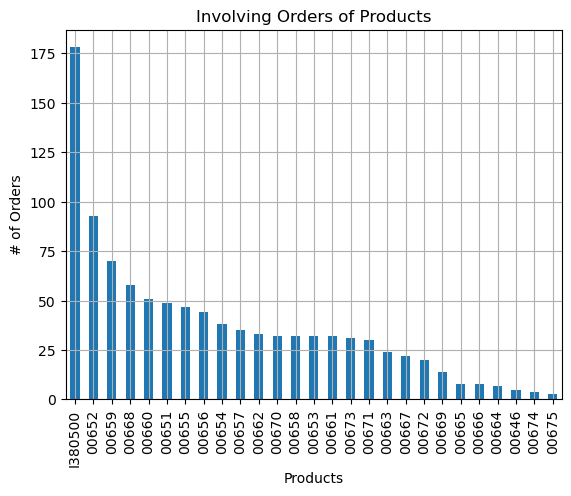

In [334]:
import pandas as pd
import matplotlib.pyplot as plt

CP_MAT=pd.read_excel(r"C:\Users\paint\OneDrive\Desktop\CP_MAT_01_배포.xlsx",index_col='Unnamed: 0')
CP_MAT=CP_MAT.T #.T는 전치(transpose), 행과 열을 바꿔줌
#axis=0,행 중심 연산/ axis=1, 열 중심 연산
CP_MAT['total']=CP_MAT.sum(axis=1)
#주문하는 품목 수가 많은 순서대로 정렬 
CP_MAT=CP_MAT.sort_values(by='total',ascending=False) #내림차순 정렬

CP_MAT['total'].plot(kind='bar')
plt.title('Involving Orders of Products')
plt.xlabel('Products')
plt.ylabel('# of Orders')
plt.grid(True)
plt.show()

I380500이 가장 많이 주문이 되는 인기 상품이다. > 주문 유도 핵심 상품   
비인기 상품은 제거, 리뉴얼, 묶음 판매 대상 고려 가능   
막대 높이 차이가 크다면 소수의 상품에 주문이 집중됨. 차이가 적다면 상품 구성이 고르게 소비되고 있음   

상위 몇 개 상품이 전체 주문의 대부분을 차지한다면 파레토 법칙(80:20) 적용 가능   
*파레토법칙: 전체 결과의 약 80%는 20%의 원인에서 비롯된다.   
상위 20%의 중요 요소에 자원 집중, 우선순위 설정, 재고 관리, 프로모션 등을 지원할 수 있다.    

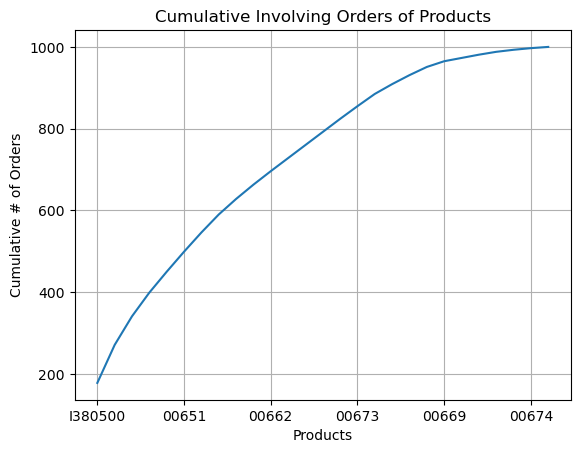

In [335]:
CP_MAT['cumtotal']=CP_MAT['total'].cumsum() #cumulative sum, 데이터를 위에서부터 하나씩 더해서 누적한 값
CP_MAT['cumtotal'].plot()
plt.title('Cumulative Involving Orders of Products')
plt.xlabel('Products')
plt.ylabel('Cumulative # of Orders')
plt.grid(True)
plt.show()

| 상황                  | 전략                         |
| ------------------- | -------------------------- |
| 누적 그래프 초반 기울기 급격함   | 인기 상품 위주 마케팅, 재고 확보, 번들 구성 |
| 누적 기여도가 고르게 분포      | 상품 다양성 유지, 전체 품목 고른 관리 필요  |
| 80% 도달에 필요한 상품 수 확인 | 파레토 분석 기반 상품군 최적화          |


주어진 CP_MAT를 가지고 처리 주문수를 최대화하는 제품 5개를 선정하는 방법   
### 1. Greedy 커버리지 선택 알고리즘    
-각 단계에서 가장 많은 추가 주문을 커버하는 제품을 선택     
-5개의 제품이 선택될 때까지 반복    

**상황 A: 부품 창고 / 제품 준비 단계**
- 아직 전체 주문을 다 처리할 수는 없지만,   
어떤 부품부터 미리 확보하면 좋은지 우선순위를 정하고 싶은 상황   
➡ 이 경우:
주문을 완전히 커버하지 않더라도,
많은 주문에 연관된 부품부터 확보하는 전략이 효율적
(그래서 *“Greedy 커버리지”*가 의미 있음)   



**상황 B: 출고 준비 / 배송 처리 단계**
- 한 주문이라도 완전히 충족되지 않으면 출고가 불가능한 상황   
➡ 이 경우:   
일부만 커버하는 건 무의미하고,   
주문 전체를 커버할 수 있어야만 의미가 있다.   
→ 이럴 땐 "전체를 충족하는 상품 조합"을 찾아야 하고,
Set Cover보다는 Exact Cover나 다른 알고리즘이 필요

In [336]:
selected_products = []
covered_orders = set()
order_cols = CP_MAT.columns.drop(['total', 'cumtotal'])  # 주문 번호들만 추출

for _ in range(5):  # 5개 상품 선택
    best_product = None
    best_new_coverage = 0
    best_orders = set()

    for product in CP_MAT.index:
        if product in selected_products:
            continue

        # 이 상품이 포함된 주문 번호
        product_orders = set(CP_MAT.loc[product, order_cols][CP_MAT.loc[product, order_cols] == 1].index)
        new_coverage = product_orders - covered_orders

        if len(new_coverage) > best_new_coverage:
            best_new_coverage = len(new_coverage)
            best_product = product
            best_orders = product_orders

    if best_product is not None:
        selected_products.append(best_product)
        covered_orders.update(best_orders)

print("선택된 상품:", selected_products)
print("커버한 주문 수:", len(covered_orders))
print("커버한 주문 번호들:", covered_orders)


선택된 상품: ['I380500', '00652', '00667', '00674', '00655']
커버한 주문 수: 217
커버한 주문 번호들: {'O240122000074', 'O240122000578', 'O240122002907', 'O240122002899', 'O240122000232', 'O240122002914', 'O240122002797', 'O240122002847', 'O240122000408', 'O240122000114', 'O240122002864', 'O240122000475', 'O240122002889', 'O240122002809', 'O240122000186', 'O240122002862', 'O240122000080', 'O240122002801', 'O240122000626', 'O240122002803', 'O240122002842', 'O240122000545', 'O240122002881', 'O240122002870', 'O240122002880', 'O240122002887', 'O240122000462', 'O240122002807', 'O240122000498', 'O240122000051', 'O240122002791', 'O240122000510', 'O240122000241', 'O240122000495', 'O240122002863', 'O240122000478', 'O240122000485', 'O240122002929', 'O240122000102', 'O240122002851', 'O240122002826', 'O240122002925', 'O240122000287', 'O240122000625', 'O240122002814', 'O240122002897', 'O240122002874', 'O240122002879', 'O240122002852', 'O240122002855', 'O240122000338', 'O240122002872', 'O240122000095', 'O240122000118',

주문 기여도 적용하기, 각 주문에 차지하는 비중 합 

### K out N Constraints Modeling(정수 계획)

| 구분 | Greedy Search | 수학 모델 (정수계획 등) |
| -- | ------------- | -------------- |
| 방식 | 탐색 기반 휴리스틱    | 수식 기반 최적화      |
| 목적 | 근사해를 빠르게 찾음   | 최적해를 정확히 찾음    |
| 장점 | 계산 빠름, 구현 쉬움  | 최적해 보장         |
| 단점 | 최적 아님         | 큰 문제에서는 계산 불가  |


In [337]:
import pandas as pd
import numpy as np
ndf=pd.read_excel(r'C:\Users\paint\OneDrive\Desktop\pr1.xlsx',header=0,index_col='Unnamed: 0')
oList = sorted(set(ndf['주문번호']))
pList = sorted(set(ndf['상품코드']))

nOrders = len(oList)
nProducts = len(pList)
print(nOrders,nProducts)

CP_MAT = pd.DataFrame(index=oList, columns=pList).fillna(0)
#.shape : (행 개수, 열 개수)를 튜플로 반환
#.shape[0] : 행 개수(데이터 수)
for i in range(ndf.shape[0]):  
    CP_MAT.loc[ndf['주문번호'][i],ndf['상품코드'][i]]=ndf['수량'][i]
CP_MAT_01=(CP_MAT !=0)*1

219 27


C:\Users\paint\AppData\Local\Temp\ipykernel_25096\2120990130.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CP_MAT = pd.DataFrame(index=oList, columns=pList).fillna(0)


In [338]:
from ortools.linear_solver import pywraplp
solver=pywraplp.Solver.CreateSolver("SAT")
BIGM=1000000
KK=3
#제품 선택 여부 
X={}
for i in range(nProducts):
    X[i]=solver.IntVar(0,1,'X[%i]'%i)
#주문 처리 여부 
Y={}
for i in range(nOrders):
    Y[i]=solver.BoolVar('Y[%i]'%i)
#제약조건
#선정된 K 제품으로 주문이 처리될 수 있는지 확인
for i in range(nOrders):
    selected=[]
    for j in range(nProducts):
        if CP_MAT_01.iloc[i,j]==True:
            selected.append(j)
    solver.Add(sum(X[k] for k in selected)+Y[i]*BIGM>=len(selected))

#선정되는 제품 수 K개
solver.Add(solver.Sum(X[i] for i in range(nProducts))==KK)

solver.Minimize(solver.Sum(Y[i] for i in range(nOrders)))
status=solver.Solve()
if status==pywraplp.Solver.OPTIMAL or status==pywraplp.Solver.FEASIBLE:
    #Y[i]가 1이면 주문이 처리되지 않은 것 
    print(nOrders-solver.Objective().Value())
    for i in range(nProducts):
        if X[i].solution_value()>0.5:
            print(CP_MAT_01.columns[i])
    for i in range(nOrders):
        #Y[i]가 0이면 주문이 처리된 것
        if Y[i].solution_value()<0.5:
            print(CP_MAT_01.index[i])
else:
    print('a')

92.0
00652
00667
I380500
O240122000094
O240122000118
O240122000235
O240122000408
O240122002788
O240122002789
O240122002791
O240122002792
O240122002794
O240122002795
O240122002796
O240122002797
O240122002798
O240122002799
O240122002800
O240122002806
O240122002807
O240122002808
O240122002809
O240122002811
O240122002812
O240122002814
O240122002816
O240122002817
O240122002818
O240122002819
O240122002823
O240122002824
O240122002825
O240122002826
O240122002827
O240122002830
O240122002831
O240122002832
O240122002833
O240122002834
O240122002836
O240122002837
O240122002842
O240122002843
O240122002844
O240122002845
O240122002847
O240122002848
O240122002849
O240122002850
O240122002851
O240122002852
O240122002856
O240122002863
O240122002864
O240122002865
O240122002867
O240122002870
O240122002873
O240122002875
O240122002878
O240122002879
O240122002885
O240122002887
O240122002888
O240122002889
O240122002890
O240122002891
O240122002892
O240122002893
O240122002894
O240122002896
O240122002898
O24012200